<a href="https://colab.research.google.com/github/sunwoongc/robust-resnet-demo/blob/main/Robust_resnet50_noisydata(revised).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import sys
import pickle
import numpy as np
from absl import flags

In [ ]:
sys.argv = sys.argv[:1]
flags.DEFINE_string("GPU_ID", '0', "Specify which GPU to train the model")
flags.DEFINE_float("h", 0.08, "Specify the value of the step size factor h (Make h smaller, training is more stable)")
flags.DEFINE_integer('n', 9, "Specify the Resisual Block number in each stack. ResNet depth = 6*n + 2")
flags.DEFINE_float("start_LR", 0.1, "Specify the initial learning rate for the optimizer")
flags.DEFINE_integer('epochs', 60, "Specify the epochs to train the model")
flags.DEFINE_integer('seed', 5, "Specify the random seed for the consistent results")
flags.DEFINE_float('noise_level', 0.25, "noise_level means the std in gaussian noise")
FLAGS = flags.FLAGS 
FLAGS(sys.argv)

['/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py']

In [ ]:
seed_num = FLAGS.seed
np.random.seed(seed_num)
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed_num)
torch.cuda.manual_seed_all(seed_num)

In [ ]:
GPU_ID = FLAGS.GPU_ID
cuda= torch.device('cuda:' + GPU_ID)
h = FLAGS.h

n = FLAGS.n # the Resisual Block number in each stacks 
block_list = [n, n, n] # we have three stacks.
start_LR = FLAGS.start_LR
num_epochs = FLAGS.epochs
noise_level = FLAGS.noise_level

In [ ]:
# Let us see how the hyper parameters are defined. 
print("\nParameters:")
print("-"*20)
for attr, value in sorted(FLAGS.__flags.items()):
    print("{}={}".format(attr, value.value))
print("")


Parameters:
--------------------
GPU_ID=0
epochs=60
h=0.75
n=9
noise_level=0.25
seed=5
start_LR=0.1



In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    AddGaussianNoise(0., noise_level)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
# choose the training and test datasets
train_data = datasets.CIFAR10('./data', train=True,
                              download=True, transform=transform_train)
test_data = datasets.CIFAR10('./data', train=False,
                             download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


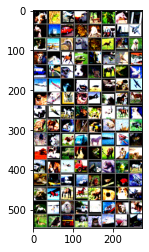

  dog  frog plane truck


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [ ]:
class BasicBlock(nn.Module):

    def __init__(self, in_channel, out_channel, stride = 1, dimension_mismatch = False):
        
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride= stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)

        self.shortcut = nn.Sequential()
        
        if dimension_mismatch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(out_channel)  # Dimensionality change for inpt x
            )            

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.shortcut(x) + h * out
        out = F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, BasicBlock, num_blocks=[2, 2, 2] , num_classes=10):
        super(ResNet, self).__init__()
        self.num_blocks = num_blocks
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        
        self.stack1 = self._make_stacks(in_channel = 16, out_channel = 16, 
                                        num_block = self.num_blocks[0], 
                                        dimension_mismatch = False)        
        self.stack2 = self._make_stacks(in_channel = 16, out_channel = 32, 
                                        num_block = self.num_blocks[1], 
                                        dimension_mismatch = True )
        self.stack3 = self._make_stacks(in_channel = 32, out_channel = 64, 
                                        num_block = self.num_blocks[2], 
                                        dimension_mismatch = True )
        
        self.linear = nn.Linear(64, num_classes)
    
    
    def _make_stacks(self, in_channel = 16, out_channel = 16, num_block = 2, dimension_mismatch = False):
        d_mismatch = dimension_mismatch
        if dimension_mismatch == False:
            stride = 1
        else:
            stride = 2
        
        layers = []
        for i in range(num_block):
            layers.append(BasicBlock(in_channel, out_channel, stride = stride, dimension_mismatch = d_mismatch ))
            d_mismatch = False
            stride = 1
            in_channel = out_channel
            
        return(nn.Sequential(*layers))
        
        
    
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))        
        out = self.stack1(out)
        out = self.stack2(out)
        out = self.stack3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
# Model
print('==> Building model ResNet Depth {}..'.format(2*sum(block_list) + 2))
#torch.backends.cudnn.benchmark = True  # faster runtime
net = ResNet(BasicBlock, num_blocks = block_list)
net = net.to(cuda)
#net = torch.nn.DataParallel(net) 




criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr= start_LR, momentum=0.9)




train_acc_list = []
test_acc_list = []

==> Building model ResNet Depth 56..


In [ ]:
def train(epoch):
    #print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(cuda), targets.to(cuda)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        #print ( (batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #    % (train_loss/(batch_idx+1), 100.*correct/total, correct, total) )  )

    acc = correct/total
    print ("###########EPOCH {}, NOISE LEVEL {}, ############# Train ACC {}".format(epoch, noise_level, acc))
    train_acc_list.append(acc)     
        
def test(epoch):
    global best_test_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(cuda), targets.to(cuda)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    # Save checkpoint.
    acc = correct/total
    print ("###########EPOCH {}, NOISE LEVEL {}, ############# Test ACC {}".format(epoch, noise_level ,acc))
    test_acc_list.append(acc)


In [ ]:
# Train
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15,30], gamma=0.1)
for epoch in range(num_epochs):
    scheduler.step()
    train(epoch)
    test(epoch)




depth = 2*sum(block_list) + 2
save_dir = 'vis_acc'
name = "seed{}depth{}epoch{}h{}start_LR{}optimzer{}noise_level{}".format(seed_num,depth, num_epochs, h, start_LR,"SGD_momentum",noise_level)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

acc = dict()
acc.update( { "test_acc": test_acc_list } )
acc.update( {"train_acc": train_acc_list} )

    
with open(save_dir + '/' + name + ".pickle", 'wb') as file:
    pickle.dump(acc, file)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


###########EPOCH 0, NOISE LEVEL 0.25, ############# Train ACC 0.31112
###########EPOCH 0, NOISE LEVEL 0.25, ############# Test ACC 0.3889
###########EPOCH 1, NOISE LEVEL 0.25, ############# Train ACC 0.47864
###########EPOCH 1, NOISE LEVEL 0.25, ############# Test ACC 0.5427
###########EPOCH 2, NOISE LEVEL 0.25, ############# Train ACC 0.59022
###########EPOCH 2, NOISE LEVEL 0.25, ############# Test ACC 0.5649
###########EPOCH 3, NOISE LEVEL 0.25, ############# Train ACC 0.66062
###########EPOCH 3, NOISE LEVEL 0.25, ############# Test ACC 0.6739
###########EPOCH 4, NOISE LEVEL 0.25, ############# Train ACC 0.71134
###########EPOCH 4, NOISE LEVEL 0.25, ############# Test ACC 0.6981
###########EPOCH 5, NOISE LEVEL 0.25, ############# Train ACC 0.74376
###########EPOCH 5, NOISE LEVEL 0.25, ############# Test ACC 0.7151
###########EPOCH 6, NOISE LEVEL 0.25, ############# Train ACC 0.77028
###########EPOCH 6, NOISE LEVEL 0.25, ############# Test ACC 0.7123
###########EPOCH 7, NOISE LEVEL 0.